# Project - Analyzing Chess Results with Python

## Data Preparation

I aim to analyze a database of classical chess games in python in order to assess how well ELO ratings can predict wins and losses, and to see if there are any more accurate ways to do so by including more variables.

In [258]:
import pandas as pd
import numpy as np 
import re
import math
import io
import annotator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import chess
import chess.pgn
import time
import chess.engine
import warnings
warnings.filterwarnings('ignore')

import seaborn as sb

In [259]:
players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','carlsen, magnus','zelcic, robert','khotenashvili, bela', 'bischoff, klaus', 'hoffmann, asa','kaufman, lawrence','bellaiche, elise']

#merging the individual csvs
dfs = []
i = 0
for player in players:
    df = pd.read_csv('blitz/' +player +'.csv', index_col=None, header=0)
    df.to_csv(str(i)+ '.csv')
    dfs.append(df)
#db = pd.concat(dfs, axis=0, ignore_index=True)

In [260]:
def to_eval(x,n):
    eval = Eval(x,n)
    return eval

In [261]:
# testing the time to run through 268 games: not going to be quick but only need to do it once
# def evaluate(dx):
#     db = dx.copy()
#     start = time.time()
#     db['Game'] = db['Game'].apply(lambda x : to_eval(x,2).centipawns)
#     end = time.time()
#     print(f"time elapsed:", end-start)
#     return db

In [262]:
# i = 0
# for df in dfs:
#     df['Centipawns'] = df['Game']
#     df.to_csv(str(i) +'.csv')
#     i +=1
# # note I haven't added the game column to the rest of the csvs, just the first. This is why I get the error. It's fine for testing to just use the first csv though

In [263]:
# for i in range(len(dfs)):
#     try:
#         df= pd.read_csv('annotated' +str(i) +'.csv')
#     except:
#         df= pd.read_csv(str(i) +'.csv')
#     for index,row in df.iterrows():
#         if row['Game'] == row['Centipawns']:
#             start = time.time()
#             df.at[index,'Game'] = to_eval(row['Game'] ,20).centipawns
#             df.to_csv('annotated' + str(i) +'.csv')
#             print(index)
#             end = time.time()
#             print(f"time elapsed:", end-start)
#     i +=1

In [264]:
# note I need to edit this so that it uses the same csvs each time

In [265]:
import scalene

In [266]:
db = pd.concat(dfs)

I will remove all blitz, rapid and correspondence games, and also remove any games with null values in any of the columns. I am also removing team games as I'm not interested in these either.

In [267]:
#Removing any rows with null values
db = db.replace('*', np.nan)
db = db.replace('?', np.nan)
db = db.dropna(subset = ['Rounds','Eval','WhiteELO','BlackELO', 'Result'])
db['WhiteELO'] = db['WhiteELO'].astype(float)
db['BlackELO'] = db['BlackELO'].astype(float)

In [268]:
#Converting rounds to numeric and rounding down
db['Rounds'] = pd.to_numeric(db['Rounds']).apply(math.floor)

In [269]:
# filtering out the games that aren't blitz
db = db[db["Event"].str.contains("blitz") == True ]

In [270]:
#Adding a column for ELO-implied expected points and ELO difference (White - Black)
db['Diff'] = db['WhiteELO'] - db['BlackELO']
db['Diff'] = pd.to_numeric(db['Diff'],errors='raise')
db['ExpWhitePoints'] = 1/(1+(10**((-db['Diff'])/400)))
db['ExpWhitePoints'] = pd.to_numeric(db['ExpWhitePoints'],errors='raise')

In [271]:
#Replacing the strings in the result column with numeric values for white's points.
db['WhitePoints'] = db['Result'].replace(r'0-\d', '0', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1-\d', '1', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1/2-\d.\d', '0.5', regex=True)
db['WhitePoints'] = pd.to_numeric(db['WhitePoints'],errors='raise')

## Exploratory Data Analysis

I would expect difference in ELO to be a strong indicator of whether white will win, draw or lose.

[Text(0.5, 1.0, "Difference in ELO vs White's points"),
 Text(0.5, 0, "White's points"),
 Text(0, 0.5, 'White ELO - Black ELO')]

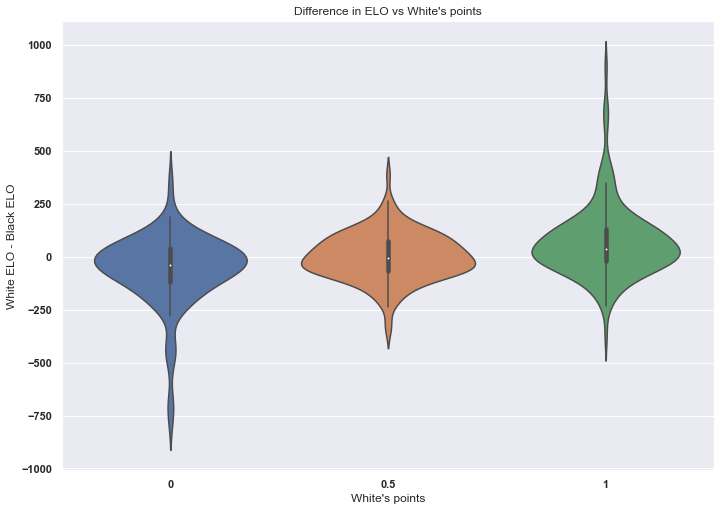

In [272]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.violinplot(x = "WhitePoints", y = "Diff", order=[0, 0.5,1],data = db).set(title = "Difference in ELO vs White's points",xlabel = "White's points", ylabel = "White ELO - Black ELO")

Text(0, 0.5, 'Average Points')

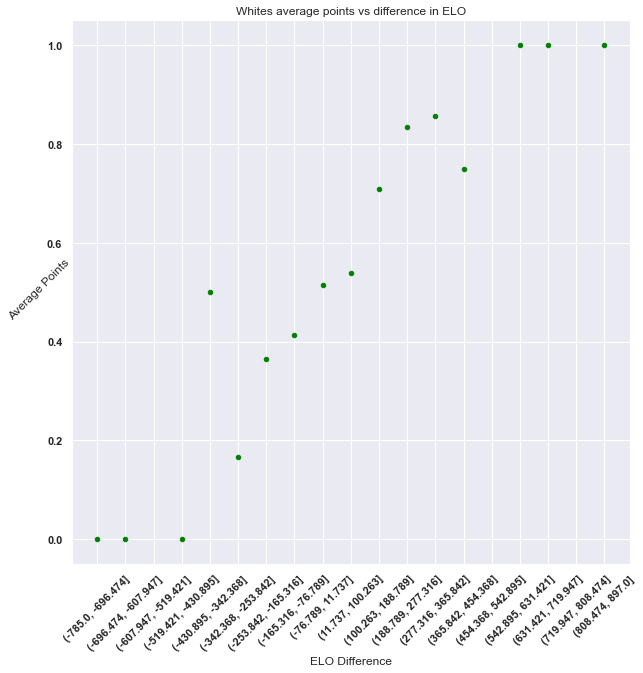

In [273]:
#Sorting the data into 20 bins by ELO Difference
lb =db['Diff'].min().astype(int)
ub = db['Diff'].max().astype(int)
db_cut = db[['Diff','WhitePoints']]
db_cut = db_cut.sort_values(by = 'Diff',ascending=True)
bins =np.linspace(lb,ub,20)
db_cut['bins'] = pd.cut(db_cut['Diff'], bins = bins)

db_cut = db_cut[['bins','WhitePoints']]
db_cut_grouped = db_cut.groupby('bins').mean()
db_cut_grouped['bins'] = db_cut_grouped.index.astype(str)
ax = db_cut_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs difference in ELO')
ax.set_xlabel('ELO Difference')
ax.set_ylabel('Average Points', rotation = 45)

Text(0, 0.5, 'Average Points')

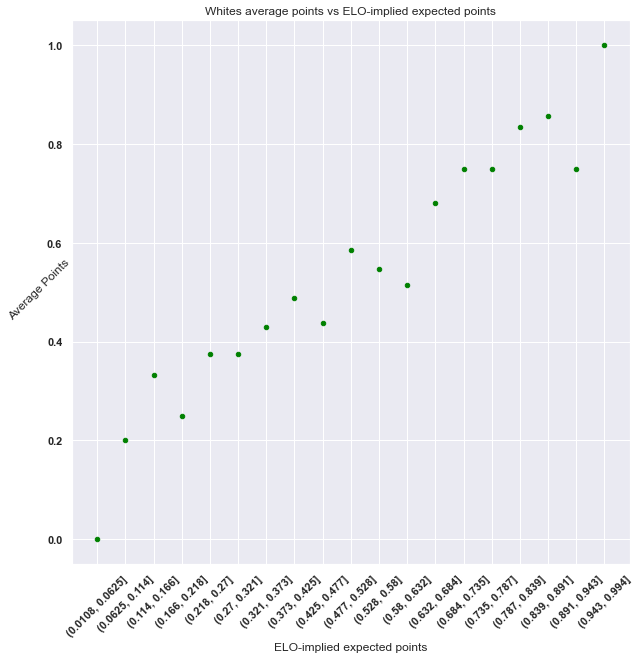

In [274]:
#Sorting the data into 20 bins by ELO-implied expected points
lb =db['ExpWhitePoints'].min().astype(float)
ub = db['ExpWhitePoints'].max().astype(float)
db_cut_ex = db[['ExpWhitePoints','WhitePoints']]
db_cut_ex = db_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
db_cut_ex['bins'] = pd.cut(db_cut_ex['ExpWhitePoints'], bins = bins)#[-1500,-1400,-1300,-1200,-1100,-1000,-900,-800,-700,-600,-500,0,1500])
db_cut = db_cut_ex[['bins','WhitePoints']]
db_cut_ex_grouped = db_cut_ex.groupby('bins').mean()
db_cut_ex_grouped['bins'] = db_cut_ex_grouped.index.astype(str)
ax =db_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs ELO-implied expected points')
ax.set_xlabel('ELO-implied expected points')
ax.set_ylabel('Average Points', rotation = 45)

This looks like a more clear linear relationship. Since I want to get the probability of a draw and a win, expected points alone doesn't provide enough information, but the mean squared error of the ELO-implied expected points might be an interesting benchmark to test a model's predicted points against.

In [275]:
print(mean_squared_error(db['WhitePoints'],db['ExpWhitePoints']))
print(mean_absolute_error(db['WhitePoints'],db['ExpWhitePoints']))

0.15209771227911653
0.3301298423623126


# Multinomial Logistic Regression

Running a multinomial regression, adding a variable 

In [276]:
#Setting a win to 2 and a draw to 1
db['WhitePoints'] = db['WhitePoints'].replace(1, 2, regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(0.5, 1, regex=True)
db['ExpWhitePoints2'] = db['ExpWhitePoints']**2
db['Diff2'] = db['Diff']**2
db['WhiteELO2'] = db['WhiteELO']**2

In [277]:
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO', 'Diff2', 'WhiteELO2']]
Y_labels = db[['WhitePoints']]
X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.25, random_state =41, shuffle = True)

In [278]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [279]:
predicted = model.predict(X_train)
print("Accuracy for Train ", round(accuracy_score(y_train,predicted),3))

Accuracy for Train  0.401


In [280]:
predicted1 = model.predict(X_test)
print("Accuracy for Test: ", round(accuracy_score(y_test,predicted1),3))

Accuracy for Test:  0.333


In [281]:
print(log_loss(y_test, model.predict_proba(X_test)))

1.0958854392666586


In [282]:
#Adding event type as a categorical variable
db= pd.get_dummies(db, columns = ['Event'])

In [283]:
print(db.columns)

Index(['Unnamed: 0', 'White', 'Black', 'WhiteELO', 'BlackELO', 'Date',
       'Result', 'Opening', 'Rounds', 'Game', 'Eval', 'EventType',
       'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Diff',
       'ExpWhitePoints', 'WhitePoints', 'ExpWhitePoints2', 'Diff2',
       'WhiteELO2', 'Event_blitz', 'Event_k.o. (blitz)', 'Event_match (blitz)',
       'Event_simul (blitz)', 'Event_swiss (blitz)', 'Event_team (blitz)',
       'Event_team-swiss (blitz)', 'Event_team-tourn (blitz)',
       'Event_tourn (blitz)'],
      dtype='object')


# Cross-Validation and Hyper-Parameter Tuning

In [284]:
#Frst running without the squared variables
X = db[['ExpWhitePoints','Diff','WhiteELO','Event_blitz', 'Rounds', 'Event_k.o. (blitz)', 'Event_match (blitz)',
       'Event_simul (blitz)', 'Event_swiss (blitz)', 'Event_team (blitz)',
       'Event_team-swiss (blitz)', 'Event_team-tourn (blitz)',
       'Event_tourn (blitz)']]
Y_labels = db[['WhitePoints']]

X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.2, random_state =66)


#my parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)

clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Score :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Score : -1.0275145120764624


In [285]:
logreg = LogisticRegression(C = .01, 
                            penalty = 'l2', 
                            solver = 'newton-cg')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

pred = logreg.predict_proba(X_test)
print(log_loss(y_test, pred))

#Examining coefficients
logreg.coef_[0]
df_0 = pd.DataFrame(logreg.coef_[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
df_1 = pd.DataFrame(logreg.coef_[1], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

df_2 = pd.DataFrame(logreg.coef_[2], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print('Loss:\n',df_0)
print('\nDraw:\n',df_1)
print('\nWin:\n',df_2)

Accuracy: 0.41379310344827586
1.065336068666856
Loss:
                               coef
Event_k.o. (blitz)        0.037316
Event_swiss (blitz)       0.014979
Event_team-tourn (blitz)  0.000802
ExpWhitePoints            0.000719
Event_simul (blitz)       0.000000
WhiteELO                 -0.000316
Diff                     -0.002742
Event_team (blitz)       -0.003711
Rounds                   -0.007478
Event_blitz              -0.008828
Event_tourn (blitz)      -0.009035
Event_team-swiss (blitz) -0.012092
Event_match (blitz)      -0.019430

Draw:
                               coef
Event_team-swiss (blitz)  0.016459
Event_team (blitz)        0.006756
Event_swiss (blitz)       0.004315
Rounds                    0.002828
WhiteELO                  0.001055
Event_team-tourn (blitz)  0.000583
Event_simul (blitz)       0.000000
Event_tourn (blitz)      -0.001242
Event_blitz              -0.001333
Diff                     -0.001417
ExpWhitePoints           -0.001717
Event_k.o. (blitz)       -0

In [286]:
#Adding in the squares of Diff, WhiteELO and ELO-implied expected points.
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO', 'BlackELO', 'Event_blitz', 'Rounds',

       # 'Event_k.o. (blitz)', 'Event_match (blitz)',
       #'Event_simul (blitz)', 'Event_swiss (blitz)', 'Event_team (blitz)',
       #'Event_team-swiss (blitz)', 'Event_team-tourn (blitz)',
       #'Event_tourn (blitz)'
        ]]
Y_labels = db[['WhitePoints']]

X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.2, random_state =66)


#my parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)

clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Score :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Score : -1.02742032497263


In [287]:
logreg = LogisticRegression(C = 100, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

pred = logreg.predict_proba(X_test)
print(log_loss(y_test, pred))

Accuracy: 0.41379310344827586
1.0711507985038307


In [288]:
#Examining coefficients
logreg.coef_[0]
df_0 = pd.DataFrame(logreg.coef_[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
df_1 = pd.DataFrame(logreg.coef_[1], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

df_2 = pd.DataFrame(logreg.coef_[2], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print('Loss:\n',df_0)
print('\nDraw:\n',df_1)
print('\nWin:\n',df_2)

Loss:
                      coef
ExpWhitePoints   0.918447
BlackELO        -0.000148
WhiteELO        -0.000165
Diff            -0.004362
Rounds          -0.010690
Event_blitz     -0.080437
ExpWhitePoints2 -0.970308

Draw:
                      coef
ExpWhitePoints   0.884825
Event_blitz      0.013638
Rounds           0.002699
Diff             0.002281
WhiteELO         0.000695
BlackELO         0.000662
ExpWhitePoints2 -4.195854

Win:
                      coef
ExpWhitePoints2  1.264527
ExpWhitePoints   0.863759
Event_blitz      0.050425
Rounds           0.004406
Diff             0.002866
WhiteELO        -0.000250
BlackELO        -0.000463


# Calculating expected points mean squared error

In [289]:
def exp_points(predictions):
    exps = []
    for prediction in predictions:
        exp = 0.5*prediction[1] + prediction[2]
        exps.append(exp)
    return exps
    
pred = logreg.predict_proba(X_test)
white_true_points = y_test/2

#Calculating MSE and MAE for the model's implied expected points
print(mean_squared_error(white_true_points,exp_points(pred)))
print(mean_absolute_error(white_true_points,exp_points(pred)))

0.16587110328230054
0.35057925606609974


In [290]:
mse_model = mean_squared_error(white_true_points,exp_points(pred))

Mean squared error and mean absolute error for our predicted points are lower than than for the implied ELO predicted points! So as well as also having a predictor of wins & draws, we seem to have a better predictor of points.

In [291]:
#Calculating MSE and MAE for the ELO-implied expected points
mse_elo = mean_squared_error(y_test/2,X_test['ExpWhitePoints'])

Text(0, 0.5, 'Average Points')

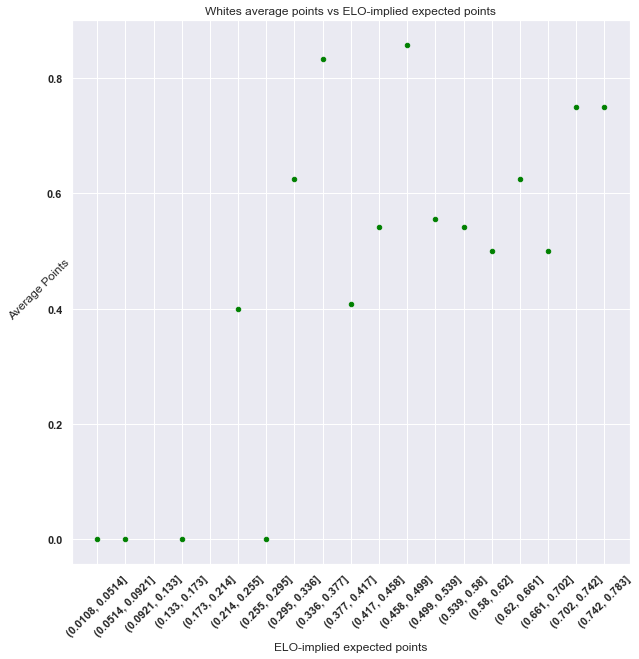

In [292]:
#Plotting ELO-implied expected points vs actual points for the test data
lb =X_test['ExpWhitePoints'].min().astype(float)
ub = X_test['ExpWhitePoints'].max().astype(float)

X_test['WhitePoints'] = y_test/2
X_test_cut_ex = X_test[['ExpWhitePoints','WhitePoints']]
X_test_cut_ex = X_test_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
X_test_cut_ex['bins'] = pd.cut(X_test_cut_ex['ExpWhitePoints'], bins = bins)
X_test_cut = X_test_cut_ex[['bins','WhitePoints']]
X_test_cut_ex_grouped = X_test_cut_ex.groupby('bins').mean()
X_test_cut_ex_grouped['bins'] = X_test_cut_ex_grouped.index.astype(str)
ax =X_test_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs ELO-implied expected points')
ax.set_xlabel('ELO-implied expected points')
ax.set_ylabel('Average Points', rotation = 45)

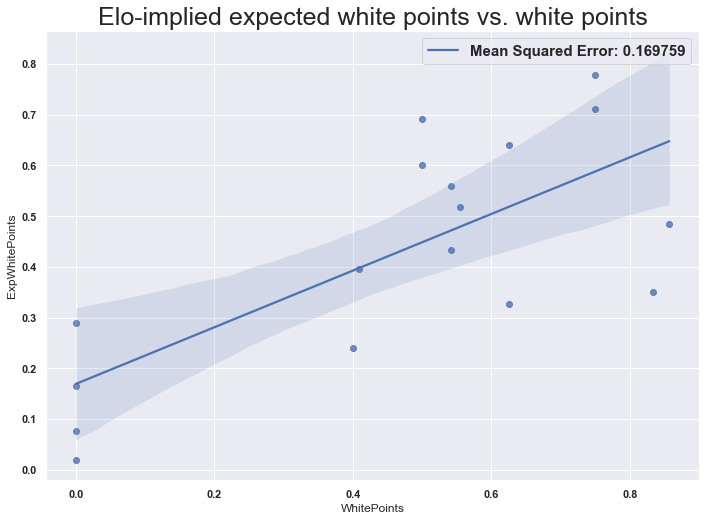

In [293]:
plt.figure()
plt.title('Elo-implied expected white points vs. white points', fontsize = 25)
sb.regplot(data = X_test_cut_ex_grouped, x = 'WhitePoints', y = 'ExpWhitePoints', line_kws = {'label':f'Mean Squared Error: {mse_elo:4f}'})
plt.legend(prop={'size': 15})
plt.savefig('images/ELO_acc.png')

Text(0, 0.5, 'Average Points')

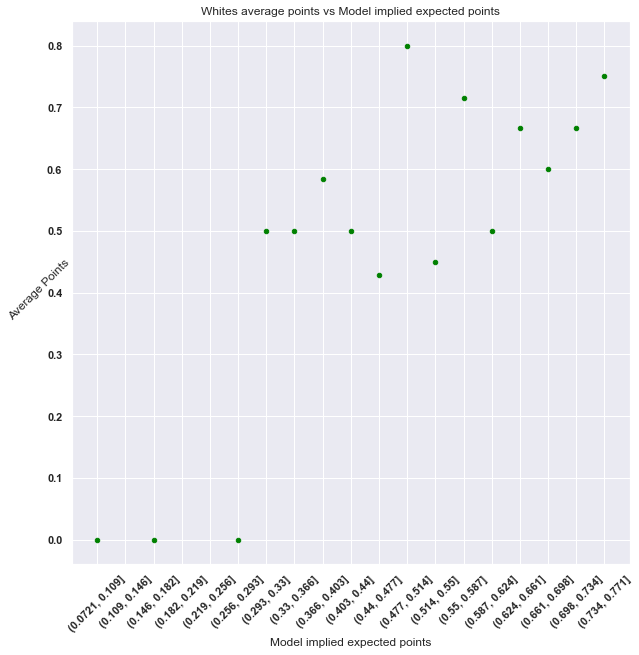

In [294]:
#Plotting the model's implied expected points vs actual points for the test data

#changing expected points to my model's expected points
X_test['ExpWhitePoints'] = exp_points(pred)

lb =X_test['ExpWhitePoints'].min().astype(float)
ub = X_test['ExpWhitePoints'].max().astype(float)
X_test['WhitePoints'] = y_test/2
X_test_cut_ex = X_test[['ExpWhitePoints','WhitePoints']]
X_test_cut_ex = X_test_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
X_test_cut_ex['bins'] = pd.cut(X_test_cut_ex['ExpWhitePoints'], bins = bins)
X_test_cut = X_test_cut_ex[['bins','WhitePoints']]
X_test_cut_ex_grouped = X_test_cut_ex.groupby('bins').mean()
X_test_cut_ex_grouped['bins'] = X_test_cut_ex_grouped.index.astype(str)
ax =X_test_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs Model implied expected points')
ax.set_xlabel('Model implied expected points')
ax.set_ylabel('Average Points', rotation = 45)

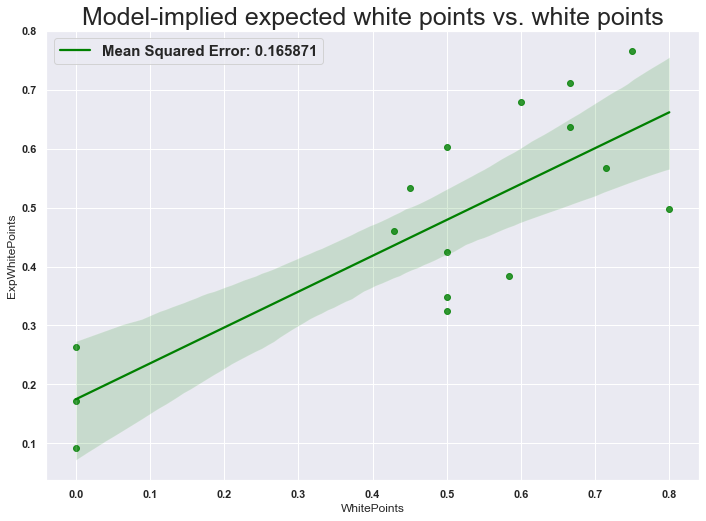

In [296]:
plt.figure()
plt.title('Model-implied expected white points vs. white points', fontsize = 25)
sb.regplot(data = X_test_cut_ex_grouped, x = 'WhitePoints', y = 'ExpWhitePoints', color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.legend(prop={'size': 15})
plt.savefig('images/Model_acc.png')